## Connect to Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import All Modules Needed

In [ ]:
import os
import shutil
import random
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras import  optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Check Tensowflow Version and ensure runtime with GPU

print("\u2022 Using TensorFlow Version:", tf.__version__)
print(
    "\u2022 GPU Device Found."
    if tf.test.is_gpu_available()
    else "\u2022 GPU Device Not Found. Running on CPU"
)

• Using TensorFlow Version: 2.17.1
• GPU Device Found.


# DATA PREPARATION

In [ ]:
# Split Dataset

# Path to original data folder
original_data_dir = "/content/drive/Shareddrives/capstone_bangkit/Pic_Dataset"
base_dir = "data_split"
os.makedirs(base_dir, exist_ok=True)

# Sub-folder for train, validation, and test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Split Ratio
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Loop for all class (monument)
for class_name in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create a class folder in each split
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # random files in each class (monument)
    files = os.listdir(class_path)
    random.shuffle(files)

    # Count the number of files for each split
    total_files = len(files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    # Split the data
    train_files = files[:train_count]
    val_files = files[train_count:train_count + val_count]
    test_files = files[train_count + val_count:]

    # Move files to their respective folders
    for file_name in train_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(train_dir, class_name, file_name))
    for file_name in val_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(val_dir, class_name, file_name))
    for file_name in test_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(test_dir, class_name, file_name))

print("The data was successfully splited!")



In [ ]:
# Move the result to another folder in shared drive
# Path to the generated file in Colab
local_file_path = '/content/data_split'

# Path to the shared drive
shared_drive_path = '/content/drive/Shareddrives/capstone_bangkit/split_dataset'

# Move the file
shutil.move(local_file_path, shared_drive_path)


# DATA PROCESSING

In [ ]:
# Directory dataset

base_dir = "/content/drive/Shareddrives/capstone_bangkit/split_dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [ ]:
# Image augmentation

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

val_data = val_datagen.flow_from_directory(val_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

Found 2226 images belonging to 12 classes.
Found 632 images belonging to 12 classes.
Found 329 images belonging to 12 classes.


In [ ]:
# Display all classes (monument) present in the dataset

class_labels = train_data.class_indices

class_labels = {v: k for k, v in class_labels.items()}

print("Classes in the dataset:")
for index, class_name in class_labels.items():
    print(f"{index}: {class_name}")

Classes in the dataset:
0: Monumen Ikada
1: Monumen Nasional
2: Monumen Perjuangan
3: Monumen Selamat Datang
4: Patung Bung Karno
5: Patung Diponegoro
6: Patung Kartini
7: Patung Kuda Arjuna Wijaya
8: Patung M.H. Thamrin
9: Patung Pembebasan Irian Barat
10: Patung Persahabatan
11: Tugu Tani


# TRANSFER LEARNING

In [ ]:
# Create base model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze the layers

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add layers
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12,activation='softmax'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,554,932 (177.59 MB)

 Trainable params: 25,693,452 (98.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Compile and train the model (without fine-tuning)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [ ]:
# Initial training (freeze base model layers)

EPOCHS_INITIAL = 10
history = model.fit(train_data, epochs=EPOCHS_INITIAL, validation_data=val_data)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 1763s 23s/step - accuracy: 0.2914 - loss: 9.8433 - val_accuracy: 0.6994 - val_loss: 1.1160
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.4979 - loss: 1.5731 - val_accuracy: 0.7389 - val_loss: 0.8732
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.5172 - loss: 1.5107 - val_accuracy: 0.7278 - val_loss: 0.9059
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.5532 - loss: 1.4320 - val_accuracy: 0.8101 - val_loss: 0.6571
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - accuracy: 0.5657 - loss: 1.3785 - val_accuracy: 0.8513 - val_loss: 0.5631
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.6191 - loss: 1.1672 - val_accuracy: 0.8244 - val_loss: 0.6319
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.6459 - loss: 1.1081 - val_accuracy: 0.8576 - val_loss: 0.5123
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.6510 - loss: 1.1363 - val_accuracy: 0.8734 - val_loss: 

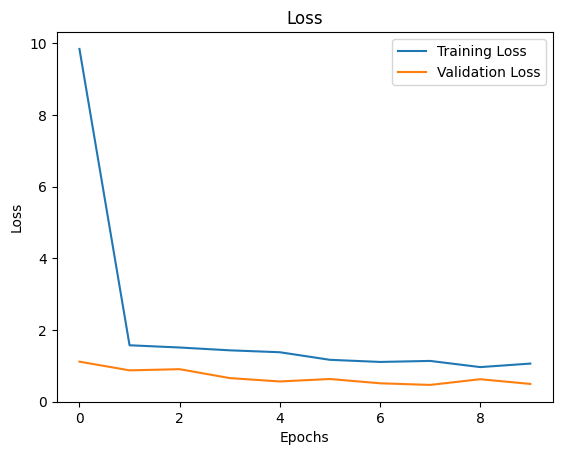

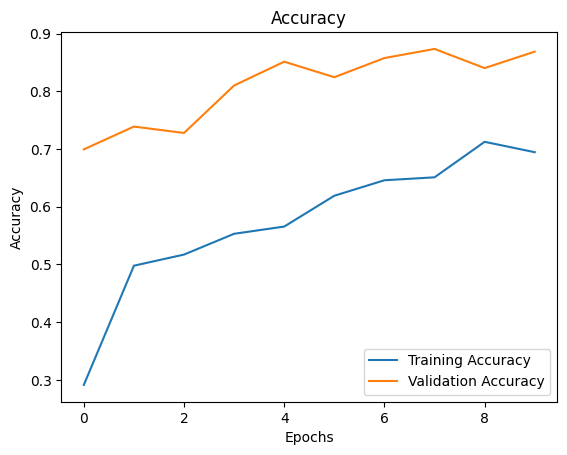

In [ ]:
# Plot Loss and Accuracy for Model Before Fine-Tuned

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Fine-tuning: Unfreeze last 30 layers

for layer in base_model.layers[-30:]:
    layer.trainable = True

In [ ]:
# Re-compile the model for fine-tuning

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [ ]:
# Fine-tuning training

EPOCHS_FINE_TUNE = 23
history_fine_tune = model.fit(train_data, epochs=EPOCHS_FINE_TUNE, validation_data=val_data)


Epoch 1/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - accuracy: 0.6077 - loss: 1.2540 - val_accuracy: 0.9193 - val_loss: 0.2982
Epoch 2/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 340s 5s/step - accuracy: 0.7963 - loss: 0.6638 - val_accuracy: 0.9604 - val_loss: 0.1395
Epoch 3/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - accuracy: 0.8275 - loss: 0.5355 - val_accuracy: 0.9668 - val_loss: 0.1239
Epoch 4/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.8752 - loss: 0.4197 - val_accuracy: 0.9620 - val_loss: 0.1509
Epoch 5/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.9091 - loss: 0.2929 - val_accuracy: 0.9873 - val_loss: 0.0522
Epoch 6/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - accuracy: 0.9251 - loss: 0.2423 - val_accuracy: 0.9921 - val_loss: 0.0442
Epoch 7/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.9313 - loss: 0.2194 - val_accuracy: 0.9905 - val_loss: 0.0532
Epoch 8/23
70/70 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.9449 - loss: 0.1649 - val_accuracy: 0.9937 - v

In [ ]:
# Model evaluation on test dataset

test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 206s 20s/step - accuracy: 0.9989 - loss: 0.0032
Test Accuracy: 1.00


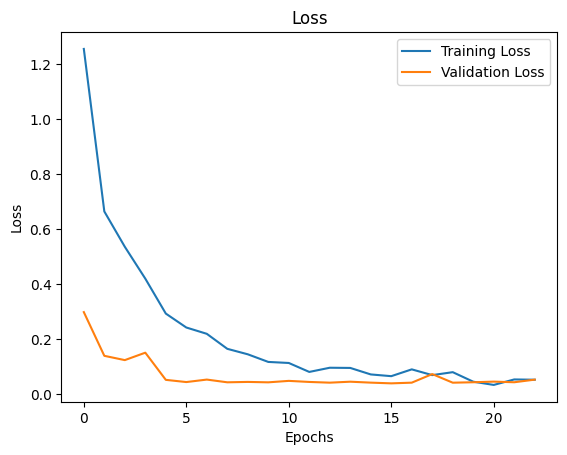

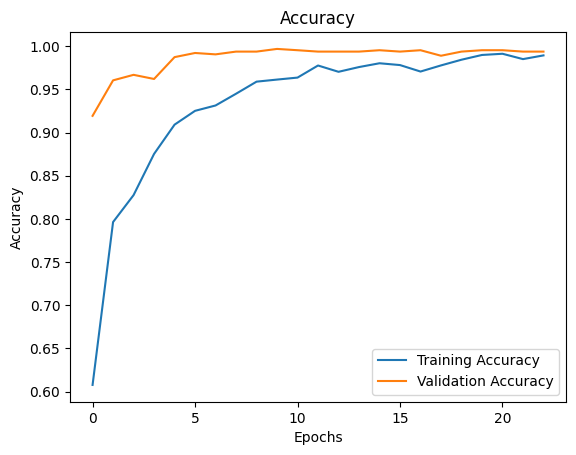

In [ ]:
# Plot Loss and Accuracy for Model After Fine-Tuned

# Plot Loss
plt.plot(history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# SAVE MODEL

In [ ]:
# Saving the model to .h5 format

saved_model_path="/content/drive/Shareddrives/capstone_bangkit/Xception_V3.h5"
tf.saved_model.save(model,saved_model_path)

In [ ]:
# Saving the model to .tflite format

converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model  =converter.convert()

with open('monument_classifier_xception_V3.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpp6qwonv1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  133655532400560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655522113520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655532045232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655532049456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655520560224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655521478784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655520922080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655520920144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655520919792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655520922256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655520

In [ ]:
# Save the history

with open('/content/drive/Shareddrives/capstone_bangkit/history_fine_tune.pkl', 'wb') as file:
    pickle.dump(history_fine_tune.history, file)

TESTING THE MODEL TO IDENTIFY PICTURE

Saving 24185773635_a252e55b0c_b.jpg to 24185773635_a252e55b0c_b.jpg
Signatures available in the model:
Signature: serving_default
{'output_0': TensorSpec(shape=(None, 12), dtype=tf.float32, name='output_0')}
{'output_0': <tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[1.2012609e-09, 1.4877141e-09, 5.4746624e-11, 4.9013404e-10,
        4.7187387e-09, 2.3253650e-09, 7.1662565e-11, 3.5043688e-09,
        3.6780180e-11, 1.0000000e+00, 8.4983479e-11, 1.6090551e-11]],
      dtype=float32)>}


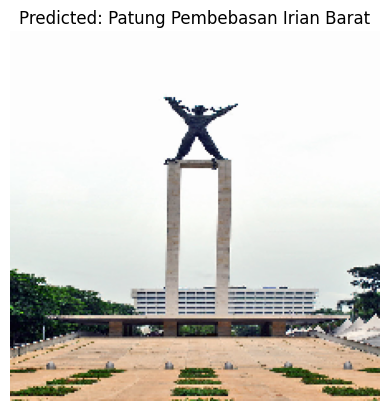

Predicted class: Patung Pembebasan Irian Barat
Prediction probabilities: [[1.2012609e-09 1.4877141e-09 5.4746624e-11 4.9013404e-10 4.7187387e-09
  2.3253650e-09 7.1662565e-11 3.5043688e-09 3.6780180e-11 1.0000000e+00
  8.4983479e-11 1.6090551e-11]]


In [ ]:
uploaded = files.upload()


saved_model_path = "/content/drive/Shareddrives/capstone_bangkit/Xception_V3.h5"
model = tf.saved_model.load(saved_model_path)


print("Signatures available in the model:")
for signature_key in model.signatures:
    print(f"Signature: {signature_key}")
    print(model.signatures[signature_key].structured_outputs)


IMG_HEIGHT = 224
IMG_WIDTH = 224


class_labels = {0: 'Monumen Ikada', 1: 'Monumen Nasional', 2: 'Monumen Perjuangan', 3: 'Monumen Selamat Datang', 4: 'Patung Bung Karno', 5: 'Patung Diponegoro', 6: 'Patung Kartini', 7: 'Patung Kuda Arjuna Wijaya', 8: 'Patung M.H. Thamrin', 9: 'Patung Pembebasan Irian Barat', 10: 'Patung Persahabatan', 11: 'Tugu Tani'}


for filename in uploaded.keys():
    img_path = '/content/' + filename

    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))


    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array = img_array / 255.0


    infer = model.signatures["serving_default"]
    predictions = infer(tf.convert_to_tensor(img_array, dtype=tf.float32))


    print(predictions)


    output = predictions[list(predictions.keys())[0]]


    class_idx = np.argmax(output, axis=-1)
    predicted_class = class_labels[class_idx[0]]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted class: {predicted_class}")
    print(f"Prediction probabilities: {output}")
